# Obesity Risk Prediction Model
This notebook develops a classification model to predict individuals at high risk for obesity based on demographic and lifestyle features. It includes data loading, preprocessing, exploratory data analysis, model training, and evaluation.

### Dataset Information

The *Obesity Levels*$\text{}^{1}$ dataset observed includes estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. The data contains 17 attributes and 2111 records, the records are labeled with the class variable NObesity (Obesity Level), that allows classification of the data using the values of Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III. 77% of the data was generated synthetically using the Weka tool and the SMOTE filter, 23% of the data was collected directly from users through a web platform.

This dataset contains the following columns:

| Column                        | Type        | Data Type   | Description                                                                                   |
|-------------------------------|-------------|-------------|-----------------------------------------------------------------------------------------------|
| **Gender**                    | Feature     | Categorical | "Gender"                                                                                      |
| **Age**                       | Feature     | Continuous  | "Age"                                                                                         |
| **Height**                    | Feature     | Continuous  | Height                                                                                        |
| **Weight**                    | Feature     | Continuous  | Weight                                                                                        |
| **family_history_with_overweight** | Feature | Binary      | "Has a family member suffered or suffers from overweight?"                                    |
| **FAVC**                      | Feature     | Binary      | "Do you eat high caloric food frequently?"                                                    |
| **FCVC**                      | Feature     | Integer     | "Do you usually eat vegetables in your meals?"                                                |
| **NCP**                       | Feature     | Continuous  | "How many main meals do you have daily?"                                                      |
| **CAEC**                      | Feature     | Categorical | "Do you eat any food between meals?"                                                          |
| **SMOKE**                     | Feature     | Binary      | "Do you smoke?"                                                                               |
| **CH2O**                      | Feature     | Continuous  | "How much water do you drink daily?"                                                          |
| **SCC**                       | Feature     | Binary      | "Do you monitor the calories you eat daily?"                                                  |
| **FAF**                       | Feature     | Continuous  | "How often do you have physical activity?"                                                    |
| **TUE**                       | Feature     | Integer     | "How much time do you use technological devices such as cell phone, videogames, television, computer and others?" |
| **CALC**                      | Feature     | Categorical | "How often do you drink alcohol?"                                                             |
| **MTRANS**                    | Feature     | Categorical | "Which transportation do you usually use?"                                                    |
| **NObeyesdad**                | Target      | Categorical | "Obesity level"                                                                               |


## 1. Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, accuracy_score
from statsmodels.stats import anova
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVR
from IPython.display import display, HTML
import itertools

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The SAMME.R algorithm.*")


## 2. Load Data
Load the dataset and examine the data.

In [9]:
data_raw = pd.read_csv('ObesityDataSet_raw.csv')
data_raw.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [11]:
# Print shape of the dataset
data_raw.shape

(2111, 17)

In [13]:
# Print information of the dataset.
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

## 3. Data Preprocessing
Convert categorical features to numeric

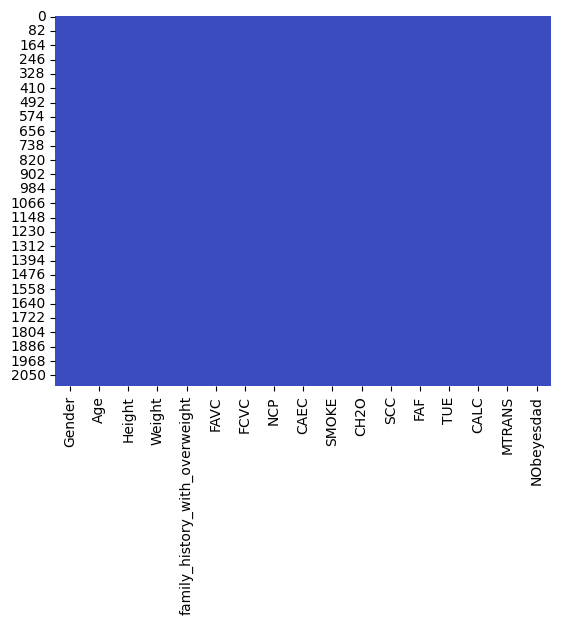

In [15]:
# Heatmap of the dataset, blue = data red = missing data
sns.heatmap(data_raw.isnull(), cbar=False, cmap="coolwarm")
plt.show() # show heatmap
# print(data_raw.isnull().sum())  # display the count of missing values for each column
# Drop missing values
#data = data_raw.dropna()  # No need to drop missing values
data = data_raw

### Data Encoding

In [17]:
# Encode categorical features
label_encoders = {}
# Dictionary to store the relationship between original and encoded values
value_mapping = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    # Store the mapping of original values to encoded values
    value_mapping[column] = dict(zip(le.classes_, range(len(le.classes_))))
    #Then, proceed with the replacement.
    label_encoders[column] = le

data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4,5
4,1,22.0,1.78,89.8,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3,6


### Data Encoded

| Column                         | Encodings                                                      |
|--------------------------------|----------------------------------------------------------------|
| **Gender**                     | Female: 0; Male: 1                                             |
| **family_history_with_overweight** | no: 0; yes: 1                                         |
| **FAVC**                       | no: 0; yes: 1                                                  |
| **CAEC**                       | Always: 0; Frequently: 1; Sometimes: 2; no: 3                  |
| **SMOKE**                      | no: 0; yes: 1                                                  |
| **SCC**                        | no: 0; yes: 1                                                  |
| **CALC**                       | Always: 0; Frequently: 1; Sometimes: 2; no: 3                  |
| **MTRANS**                     | Automobile: 0; Bike: 1; Motorbike: 2; Public_Transportation: 3; Walking: 4 |
| **NObeyesdad**                 | Insufficient_Weight: 0; Normal_Weight: 1; Obesity_Type_I: 2; Obesity_Type_II: 3; Obesity_Type_III: 4; Overweight_Level_I: 5; Overweight_Level_II: 6 |


## 4. Exploratory Data Analysis (EDA)
Explore the distribution of obesity levels and visualize relationships between features.

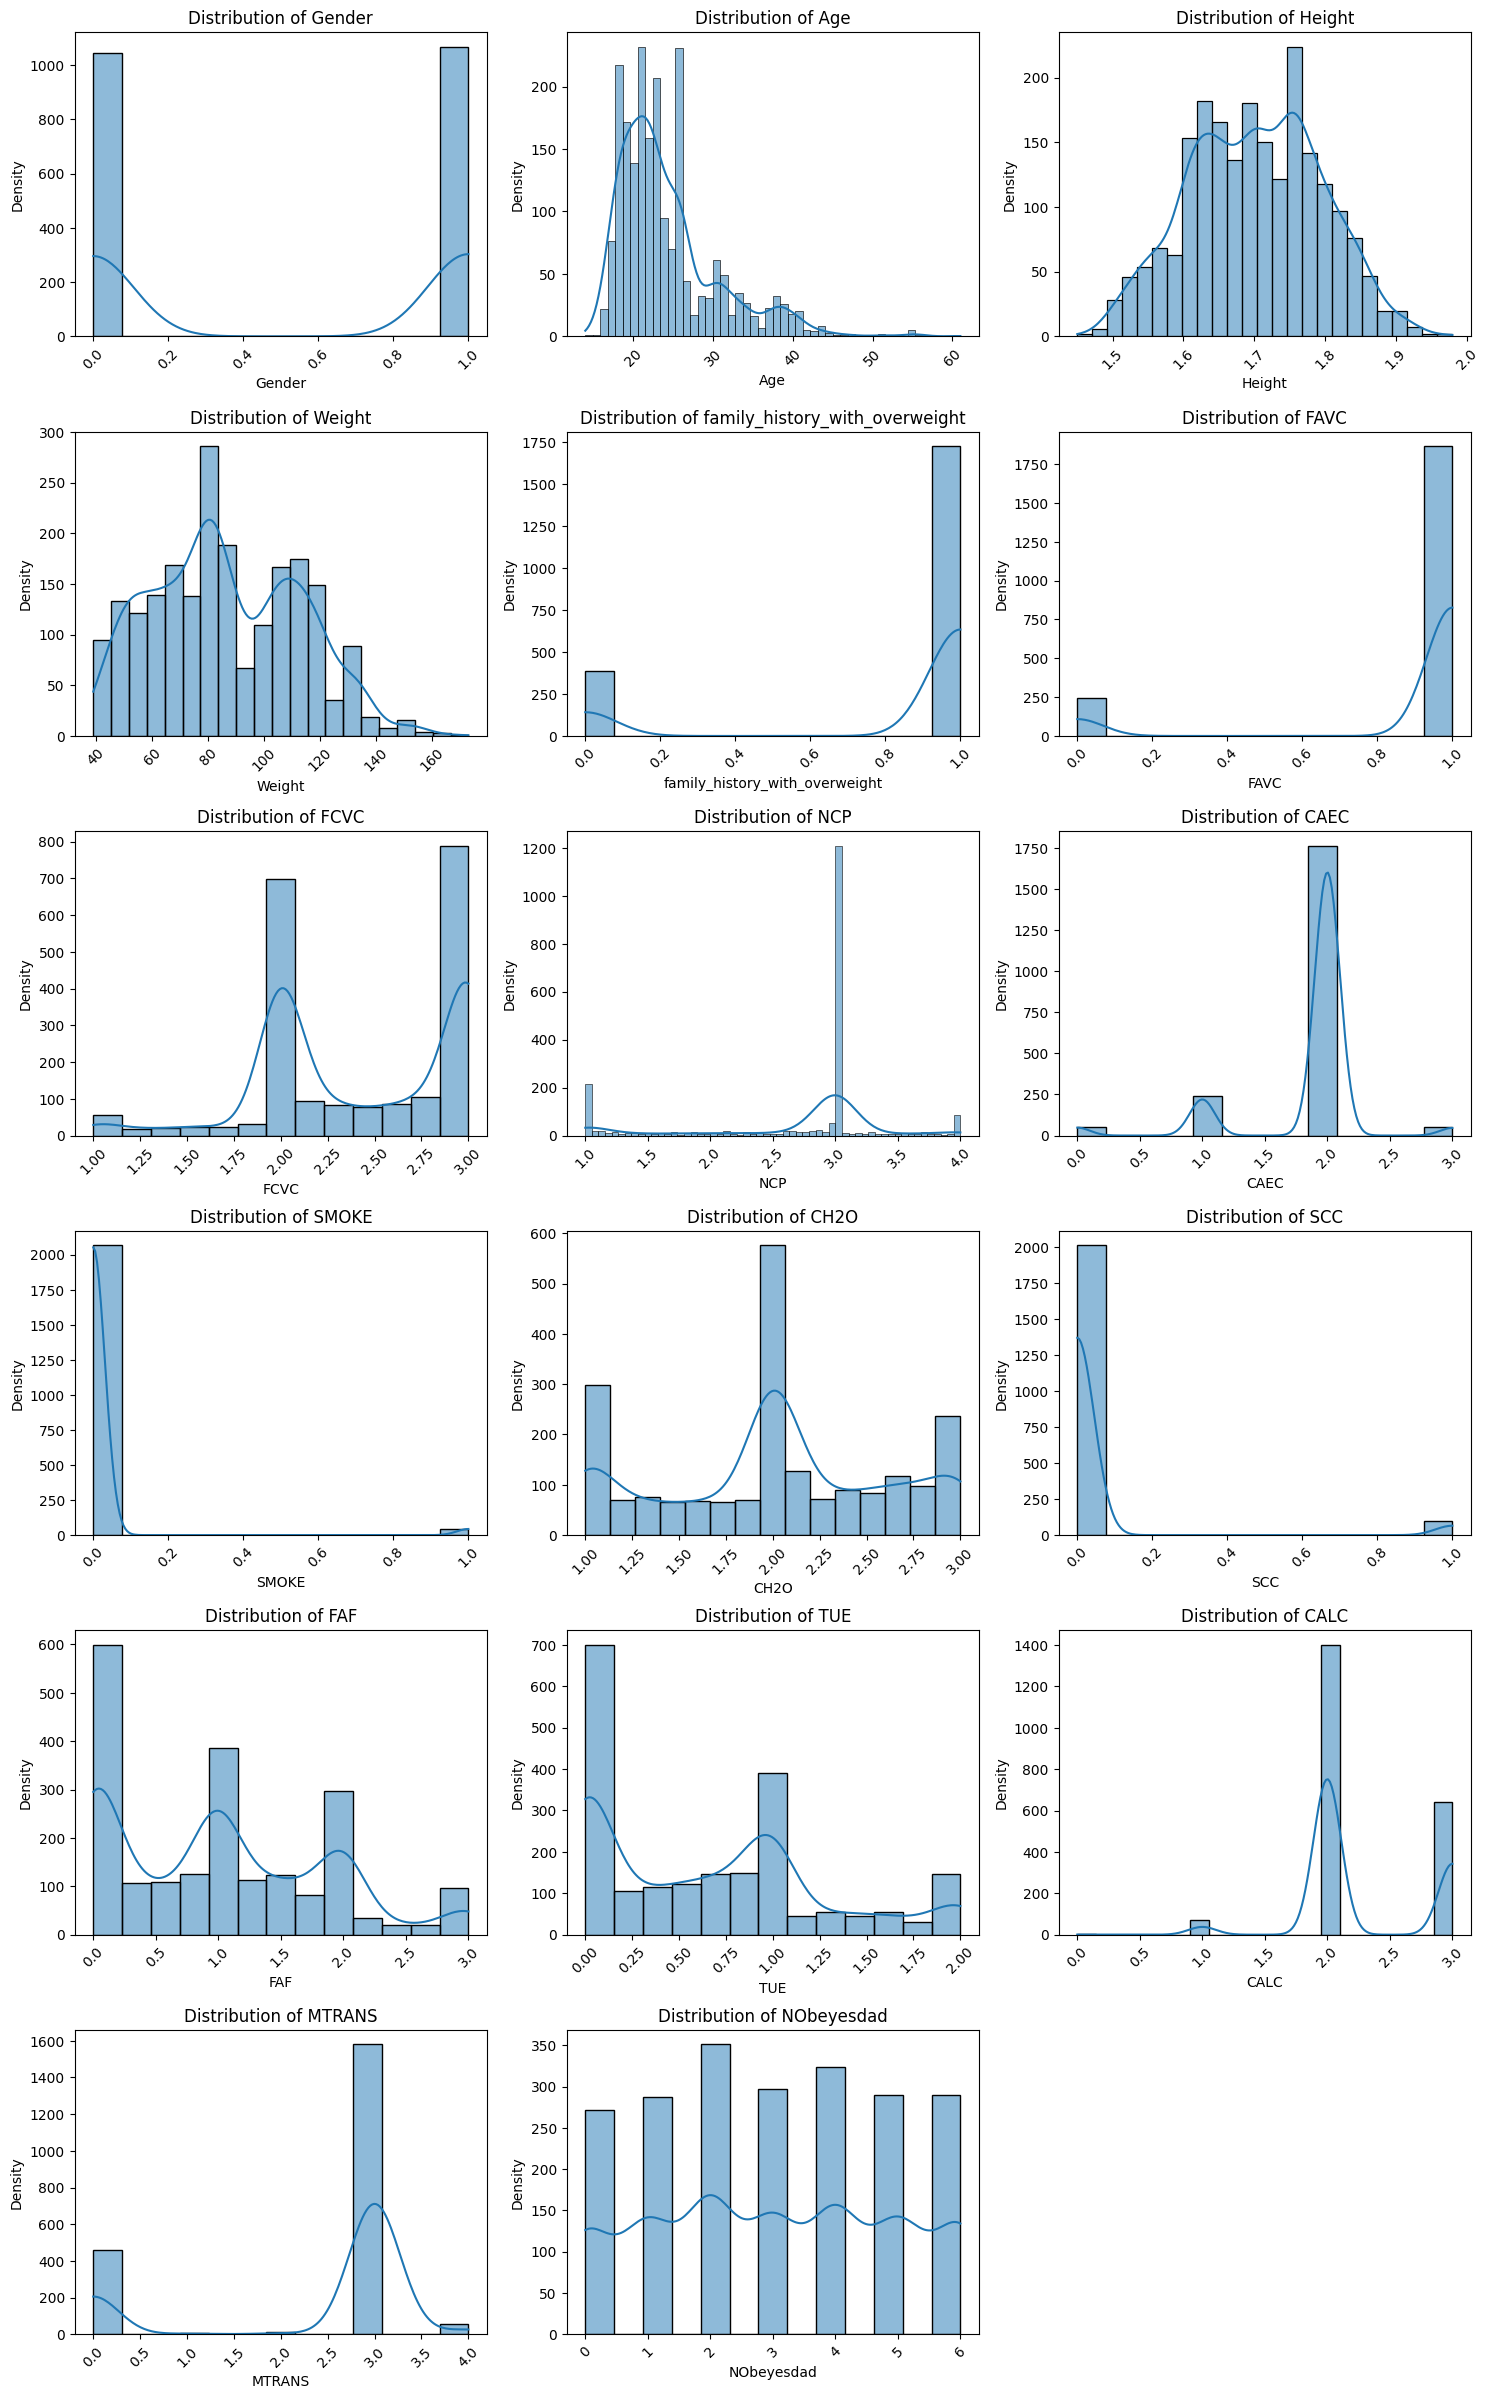

In [19]:
# Set up the number of columns for the grid
num_cols = 3
num_vars = len(data_raw.columns)
num_rows = (num_vars + num_cols - 1) // num_cols  # Calculate required number of rows

# Create a grid of subplots for all variables
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, column in enumerate(data_raw.columns):
    ax = axes[i]
    if data_raw[column].dtype == 'object':  # Plot count plot for categorical variables
        sns.countplot(x=column, data=data_raw, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)  # Rotate labels for count plot
    else:
        # Plot histogram for numerical variables
        sns.histplot(data_raw[column], kde=True, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Density')
        ax.tick_params(axis='x', rotation=45)  # Rotate labels for histogram

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Correlation matrix 
This matrix shows the correlation coefficients between variables. Each cell in the table shows the correlation between two variables. 

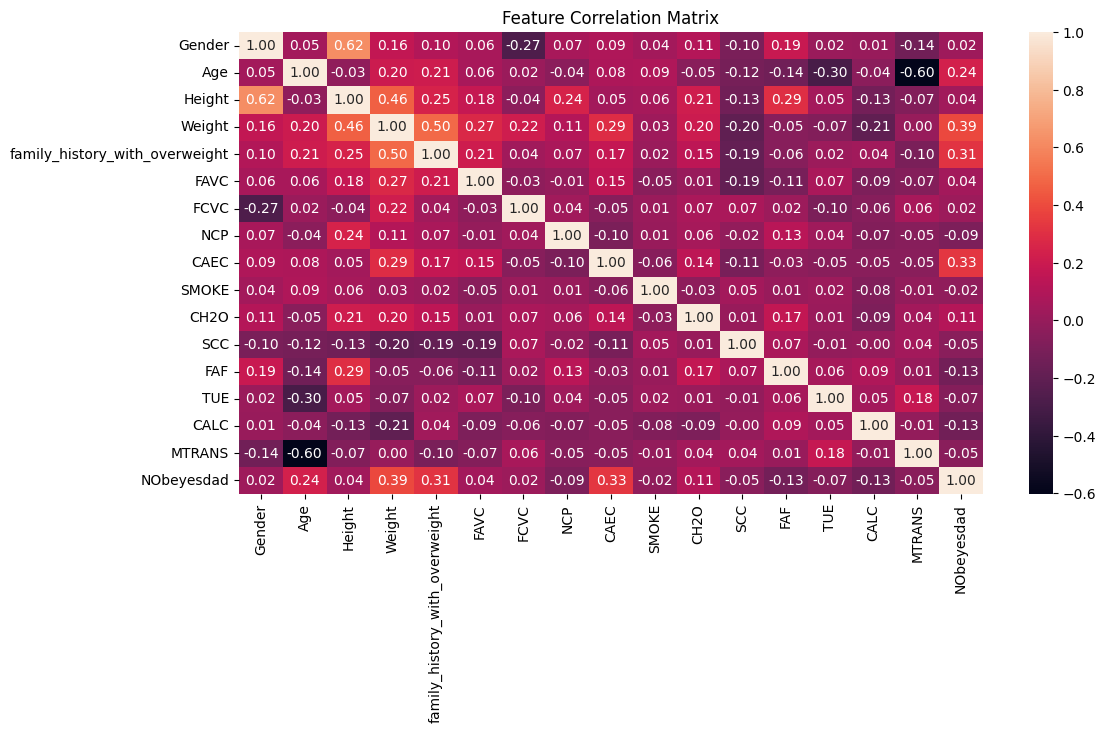

In [21]:
# Correlation matrix
plt.figure(figsize=(12,6)) # Adjust size for readability
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

## 5. Train-Validation-Test Split
Split the data into training, validation and testing sets.

In [25]:
RANDOM_SEED = 42 # Define our random seed

X = data.drop('NObeyesdad', axis=1)
y = data['NObeyesdad']

# Split into train (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X,                        # Features variables
                                                    y,                        # Target variable
                                                    test_size=0.4,            # 40% of the data (20% for test, 20% for validation) 
                                                    random_state=RANDOM_SEED) # Set random seed

X_val, X_test, y_val, y_test = train_test_split(X_temp, 
                                                y_temp, 
                                                test_size=0.5,                # Split test/validation sets. 
                                                random_state=RANDOM_SEED)


In [27]:
# Standardize training/validation/test data
# Standarizing data after splitting to avoid information leakage
scaler = StandardScaler() 
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scale = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
X_val_scale = pd.DataFrame(scaler.fit_transform(X_val), columns=X_val.columns, index=X_val.index)

## 6. Model Training
Train multiple models and compare performance.

### Model Selection
The following code was designed to streamline the process of training, evaluating, and comparing classification machine learning models. It provides an approach for handling various classification models with minimal code repetition.

In [29]:
# Initial model exploration
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_SEED),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=RANDOM_SEED),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=RANDOM_SEED),
    'AdaBoost Classifier': AdaBoostClassifier(random_state=RANDOM_SEED),
    'Bagging Classifier': BaggingClassifier(random_state=RANDOM_SEED),
    'SVC': SVC(random_state=RANDOM_SEED),
    'MLP Classifier': MLPClassifier(random_state=RANDOM_SEED)
}

models_accuracy = [] # Store models accuracy
i=0
for i, (model_name, model) in enumerate(models.items()):
    # Train the model
    model.fit(X_train_scale, y_train)

    # Validate Predictions
    val_y_pred = model.predict(X_val_scale)
    val_accuracy = accuracy_score(y_val, val_y_pred)
    val_f1 = f1_score(y_val, val_y_pred, average='weighted')

    # Store results
    models_accuracy.append([model_name, val_accuracy, val_f1])

# Create a DataFrame from the array
eval_models = pd.DataFrame(models_accuracy, columns=[
    'Model', 'Validation Accuracy', 'Validation F1-Score'
])
eval_models = eval_models.sort_values(by='Validation Accuracy', ascending=False)  # Sort by Validation Accuracy

display(eval_models)

,Model,Validation Accuracy,Validation F1-Score
3,Gradient Boosting Classifier,0.928910,0.928202
1,Random Forest,0.924171,0.924423
5,Bagging Classifier,0.919431,0.918744
2,Decision Tree Classifier,0.909953,0.909223
7,MLP Classifier,0.909953,0.910305
6,SVC,0.855450,0.855518
0,Logistic Regression,0.850711,0.848492
4,AdaBoost Classifier,0.322275,0.199634


We will focus on the top three performing models for further in-depth analysis and exploration

## 7. Hyperparameter Tuning

### Feature Combinations
This cell calculates all possible feature combinations from the dataset to identify the most impactful feature set.

In [31]:
#We'll analyze all the combinations of the features to see how the model performs.
all_features = data_raw.columns[:-1]
combinations = []
for r in range(1, len(all_features) + 1):  # r is the size of the combination (1 to len(features))
    combinations.extend(itertools.combinations(all_features, r))

# Print all combinations
print(f'Total Combinations: {len(combinations)}')
df_FeatureAnalysis = pd.DataFrame(combinations)
df_FeatureAnalysis['ValidationAccuracy'] = 0
df_FeatureAnalysis['TestAccuracy'] = 0
#for combo in combinations:
#    print(combo)

Total Combinations: 65535


In [33]:
#   Class ModelSelector - Useful during our feature selection phase. This code is designed to run a specified selection of features with a specified model.
class ModelSelector:
    def __init__(
        self,
        X,
        y,
        testingSize=0.2,
        randomSeed=42,
        validationSize=0.25,
        selectedModel="RandomForestClassifier",
        selectedColumns = []
):
        '''
        The class has the following parameters:
        X: Features
        y: Target column
        testingSize: Float number from 0 to 1 representing the percentage that will be assigned to the testing set
        randomSeed: Value for reproducibility in randomization (Random state)
        validationSize: Float number from 0 tp 1 representing the percentage that will be assigned to the validation set
        selectedModel: Model to be tested by the class.
        selectedColumns: The list of columns used for the analysis. By default it is an empty list that will be replaced by the full list of columns
        '''
        self.model_name = selectedModel
        self.selectedModels = {
            "RandomForestClassifier": {
                "model": lambda X, y: RandomForestClassifier(),
                "fit": lambda X, y: self.selectedModel.fit(X, y)
            },
            "DecisionTreeClassifier": {
                "model": lambda X, y: DecisionTreeClassifier(),
                "fit": lambda X, y: self.selectedModel.fit(X, y)
            },
            "GradientBoostingClassifier": {
                "model": lambda X, y: GradientBoostingClassifier(),
                "fit": lambda X, y: self.selectedModel.fit(X, y)
            },
            "AdaBoostClassifier": {
                "model": lambda X, y: AdaBoostClassifier(),
                "fit": lambda X, y: self.selectedModel.fit(X, y)
            },
            "BaggingClassifier": {
                "model": lambda X, y: BaggingClassifier(),
                "fit": lambda X, y: self.selectedModel.fit(X, y)
            },
            "SVC": {
                "model": lambda X, y: SVC(),
                "fit": lambda X, y: self.selectedModel.fit(X, y)
            },
            "MLPClassifier": {
                "model": lambda X, y: MLPClassifier(),
                "fit": lambda X, y: self.selectedModel.fit(X, y)
            },
            "LogisticRegression":{
                "model": lambda X, y: LogisticRegression(),
                "fit": lambda X, y: self.selectedModel.fit(X, y)
            }
        }
        if(len(selectedColumns)==0):
            selectedColumns = X.columns
        self.selectedColumns = selectedColumns
        self.X = X[selectedColumns]
        self.y = y
        self.testingSize = testingSize
        self.randomSeed = randomSeed
        self.validationSize = validationSize
        self.X_train = X_train_scale[selectedColumns]
        self.y_train = y_train
        self.X_test = X_test_scale[selectedColumns]
        self.y_test = y_test
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train,
            self.y_train,
            test_size=self.validationSize,
            random_state=self.randomSeed
)
        self.selectedModel = self.selectedModels[self.model_name]['model'](self.X_train, self.y_train)

    @staticmethod
    def getAvailableModels():
        return [
            "RandomForestClassifier",
            "DecisionTreeClassifier",
            "GradientBoostingClassifier",
            "AdaBoostClassifier",
            "BaggingClassifier",
            "SVC",
            "MLPClassifier",
            "LogisticRegression"
]

    def train(self):
        self.selectedModel=self.selectedModels[self.model_name]['fit'](self.X_train, self.y_train)
        return self.evaluate(self.X_train, self.y_train)

    def predict(self, X):
        return self.selectedModel.predict(X)
    
    def validate(self):
        return self.evaluate(self.X_val, self.y_val)
    
    def test(self):
        return self.evaluate(self.X_test, self.y_test)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        try:
            acc_score = accuracy_score(y, y_pred)
        except Exception as e:
            acc_score = 0
            #print(f'An exception has occurred with model {self.model_name}: {e}')
            #print(y.head())
            #print(y_pred[:5])
        return np.round((mse, mae, r2, acc_score), decimals=2)
    
    def summary(self):
        return self.selectedModel.summary()
    
    def plotResiduals(self, X, y):
        residuals = y - self.predict(X)
        sns.scatterplot(x=self.predict(X), y=residuals)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Predicted Values vs. Residuals')
        plt.show()

    def plot_residuals(self):
        self.plotResiduals(self.X_val, self.y_val)
    
    def plot_residuals_test(self):
        self.plotResiduals(self.X_test, self.y_test)

    def plot_residuals_val(self):
        self.plotResiduals(self.X_val, self.y_val)

### Evaluate Features Combinations
This cell evaluates the model's performance across all possible feature combinations to identify the most impactful feature set.**

> ⚠️ **WARNING**: Running this code may take over **7 hours**, so only run it if absolutely necessary.

In [37]:
skip_cell = True

if skip_cell:
    print("Skipping this cell...")
else:
    i=0
    maxLen = len(df_FeatureAnalysis)
    for i in range(maxLen): ##itertuples(index=True, name='Row'):
       row = df_FeatureAnalysis.loc[i]
       #We'll test all the combinations of variables for the RandomForestClassifier, and store their Validation Accuracy scores and Test Accuracy scores in the same dataframe
       #First, we'll select the columns dynamically from the row, excluding any columns with value 'None'
       selected_columns = []
       for col in df_FeatureAnalysis.columns[:-2]:
           if(row[col]!=None):
               selected_columns.append(row[col])
       currentModel = ModelSelector(X_train_scale[selected_columns], y_train, selectedModel='RandomForestClassifier', selectedColumns = selected_columns)
       trainingResults = currentModel.train()
       validationResults = currentModel.validate()
       testingResults = currentModel.test()
       
       #Then, we update the dataframe's columns of ValidationAccuracy and TestAccuracy
       df_FeatureAnalysis.loc[i, 'ValidationAccuracy'] = validationResults[3]
       df_FeatureAnalysis.loc[i, 'TestAccuracy'] = testingResults[3]
       i=i+1
    
    df_FeatureAnalysis.to_csv('df_FeatureAnalysis.csv')
    print(df_FeatureAnalysis.head(10))

Skipping this cell...


### Evaluate Selected Feature Combinations
This subsection analyzes the performance of the top three models across various selected feature combinations.

In [14]:
# Initialize Top 3 models
models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Bagging Classifier': BaggingClassifier(),
}

num_models = len(models) # Number of models
cols = 3  # Number of columns for the grid
rows = (num_models + cols - 1) // cols  # Required rows

### Features: Height, Weight, FAVC, CH2O and TUE

,Model,Test Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.952719,0.953131,0.952719,0.952814
1,Gradient Boosting Classifier,0.943262,0.944851,0.943262,0.943145
2,Bagging Classifier,0.931442,0.933088,0.931442,0.931231


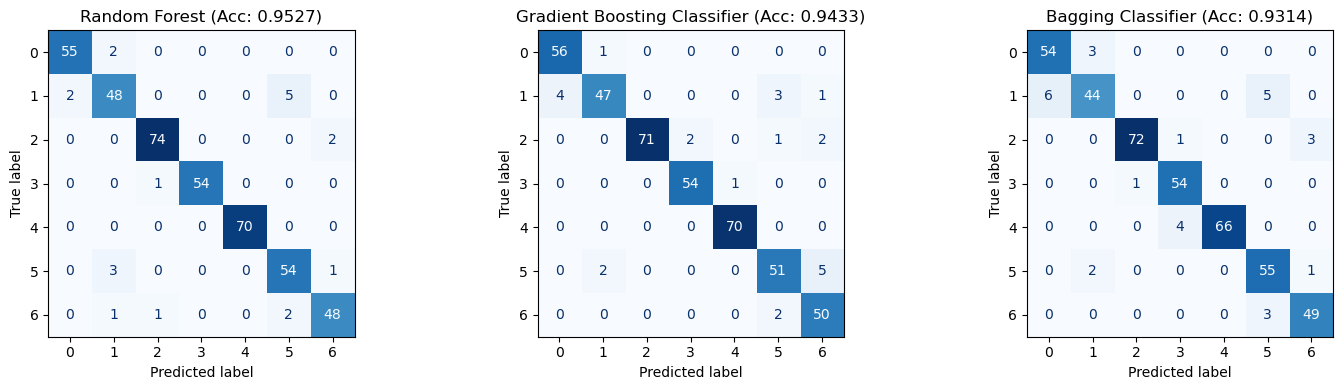

In [15]:
# Grid for confusion matrices
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4)) # size considering number of rows
axes = axes.flatten()  # Flatten axes array for easy iteration

selected_columns = ['Height','Weight','FAVC','CH2O','TUE']
X_train_scale_select = X_train_scale[selected_columns]
X_test_scale_select = X_test_scale[selected_columns]

test1_models_accuracy = []

i=0
for i, (model_name, model) in enumerate(models.items()):
    # Train the model
    model.fit(X_train_scale_select, y_train)

    # Test Predictions
    y_pred = model.predict(X_test_scale_select) # Predict on the test set
    accuracy = accuracy_score(y_test, y_pred)   # Calculate accuracy
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store metrics
    test1_models_accuracy.append([model_name, accuracy, precision, recall, f1])

    # Get confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    
    # Plot confusion matrix in the grid
    disp.plot(cmap='Blues', ax=axes[i], colorbar=False)
    axes[i].set_title(f'{model_name} (Acc: {accuracy:.4f})')

# Create a DataFrame from the array
test1_eval_models = pd.DataFrame(test1_models_accuracy, columns=[
    'Model', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score'
])
test1_eval_models = test1_eval_models.sort_values(by='Test Accuracy', ascending=False)  # Sort by Validation Accuracy

display(test1_eval_models)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Features: Gender, Height and Weight

,Model,Test Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.950355,0.951310,0.950355,0.950372
2,Bagging Classifier,0.947991,0.948815,0.947991,0.948223
1,Gradient Boosting Classifier,0.933806,0.935084,0.933806,0.933931


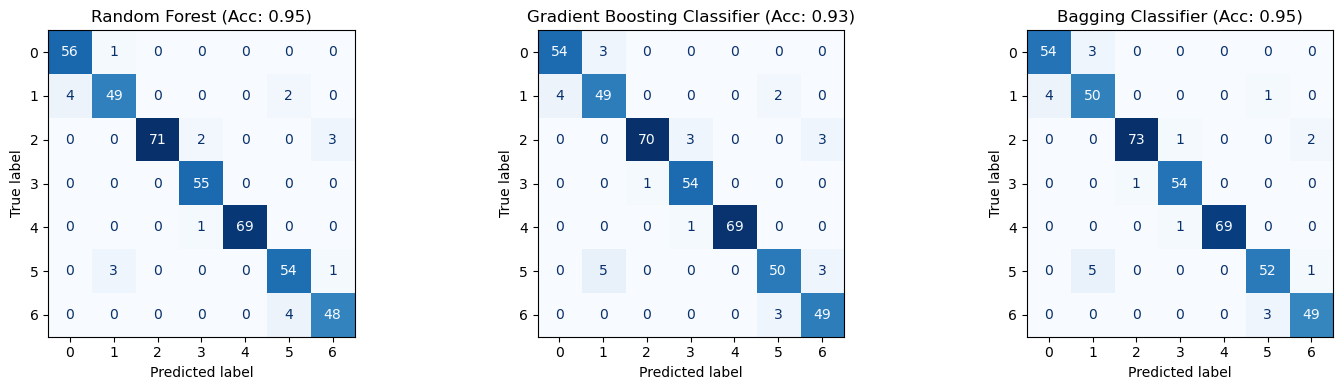

In [16]:
# Grid for confusion matrices
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4)) # size considering number of rows
axes = axes.flatten()  # Flatten axes array for easy iteration

selected_columns = ['Gender','Height','Weight']
X_train_scale_select = X_train_scale[selected_columns]
X_test_scale_select = X_test_scale[selected_columns]

test2_models_accuracy = []

i=0
for i, (model_name, model) in enumerate(models.items()):
    # Train the model
    model.fit(X_train_scale_select, y_train)

    # Test Predictions
    y_pred = model.predict(X_test_scale_select) # Predict on the test set
    accuracy = accuracy_score(y_test, y_pred)   # Calculate accuracy
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store metrics
    test2_models_accuracy.append([model_name, accuracy, precision, recall, f1])

    # Get confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    
    # Plot confusion matrix in the grid
    disp.plot(cmap='Blues', ax=axes[i], colorbar=False)
    axes[i].set_title(f'{model_name} (Acc: {accuracy:.2f})')

# Create a DataFrame from the array
test2_eval_models = pd.DataFrame(test2_models_accuracy, columns=[
    'Model', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score'
])
test2_eval_models = test2_eval_models.sort_values(by='Test Accuracy', ascending=False)  # Sort by Validation Accuracy

display(test2_eval_models)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Features: Height, Weight

,Model,Test Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.952719,0.953540,0.952719,0.952774
2,Bagging Classifier,0.950355,0.951011,0.950355,0.950500
1,Gradient Boosting Classifier,0.933806,0.934726,0.933806,0.933977


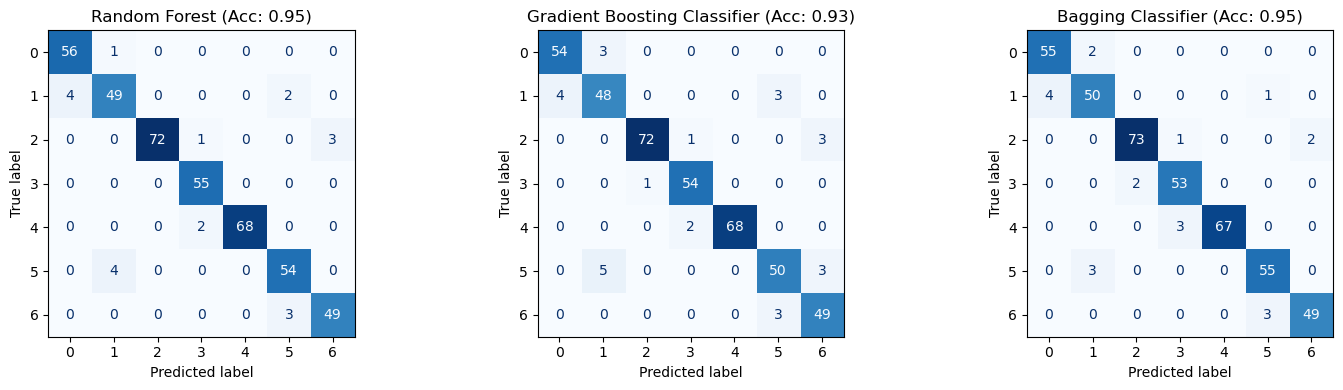

In [17]:
# Grid for confusion matrices
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4)) # size considering number of rows
axes = axes.flatten()  # Flatten axes array for easy iteration

selected_columns = ['Height','Weight']
X_train_scale_select = X_train_scale[selected_columns]
X_test_scale_select = X_test_scale[selected_columns]

test3_models_accuracy = []

i=0
for i, (model_name, model) in enumerate(models.items()):
    # Train the model
    model.fit(X_train_scale_select, y_train)

    # Test Predictions
    y_pred = model.predict(X_test_scale_select) # Predict on the test set
    accuracy = accuracy_score(y_test, y_pred)   # Calculate accuracy
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store metrics
    test3_models_accuracy.append([model_name, accuracy, precision, recall, f1])

    # Get confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    
    # Plot confusion matrix in the grid
    disp.plot(cmap='Blues', ax=axes[i], colorbar=False)
    axes[i].set_title(f'{model_name} (Acc: {accuracy:.2f})')

# Create a DataFrame from the array
test3_eval_models = pd.DataFrame(test3_models_accuracy, columns=[
    'Model', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score'
])
test3_eval_models = test3_eval_models.sort_values(by='Test Accuracy', ascending=False)  # Sort by Validation Accuracy

display(test3_eval_models)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Based on the performance of the top three models, ***Height*** and ***Weight*** have been selected as the features for further analysis. 

## 8. Model Evaluation
This cell performs a simulation-based evaluation of three machine learning models (Random Forest, Gradient Boosting, and Bagging Classifier) by iterating multiple times to assess their accuracy on different training-test splits. It also visualizes the distribution of accuracy scores for each model.

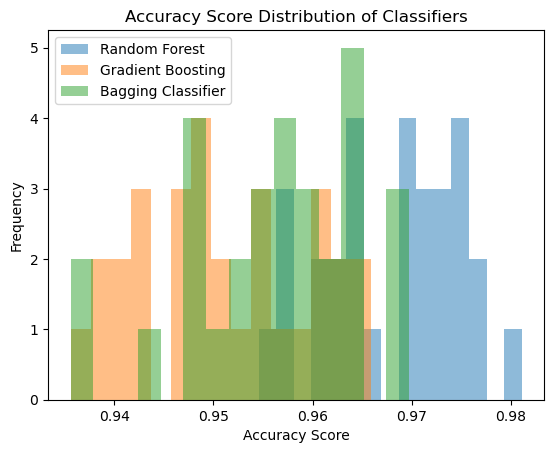

In [18]:
Iterations = 30 # Iterations

# Lists to store accuracy scores for each model
rf_scores = [] # Random Forest
gb_scores = [] # Gradient Boosting 
bc_scores = [] # Bagging Classifier

rf_model = models['Random Forest']
gb_model = models['Gradient Boosting Classifier']
bc_model = models['Bagging Classifier']

selected_columns = ['Height','Weight']

i=0
for i in range(Iterations):
    # Splits the data into training/test sets
    _x_train, _x_test, _y_train, _y_test = train_test_split(X[selected_columns], y, test_size=0.25)

    # Standardizes training/test data
    _x_train_scaled = pd.DataFrame(scaler.fit_transform(_x_train), columns=_x_train.columns, index=_x_train.index)
    _x_test_scaled = pd.DataFrame(scaler.transform(_x_test), columns=_x_test.columns, index=_x_test.index)

    # Trains and evaluates Random Forest
    rf_model.fit(_x_train_scaled, _y_train)
    _rf_predictions = rf_model.predict(_x_test_scaled)
    _rf_score = accuracy_score(_y_test, _rf_predictions)

    # Trains and evaluates Gradient Boosting 
    gb_model.fit(_x_train_scaled, _y_train)
    _gb_predictions = gb_model.predict(_x_test_scaled)
    _gb_score = accuracy_score(_y_test, _gb_predictions)

    # Trains and evaluates Bagging Classifier 
    bc_model.fit(_x_train_scaled, _y_train)
    _bc_predictions = bc_model.predict(_x_test_scaled)
    _bc_score = accuracy_score(_y_test, _bc_predictions)
    
    # Collects the scores 
    rf_scores.append(_rf_score)
    gb_scores.append(_gb_score)
    bc_scores.append(_bc_score)

# Plot histograms of the scores
plt.hist(rf_scores, bins=15, alpha=0.5, label='Random Forest')
plt.hist(gb_scores, bins=15, alpha=0.5, label='Gradient Boosting')
plt.hist(bc_scores, bins=15, alpha=0.5, label='Bagging Classifier')

#  Title, Labels, and Legend
plt.legend()
plt.xlabel("Accuracy Score")
plt.ylabel("Frequency")
plt.title("Accuracy Score Distribution of Classifiers")
plt.show()

## 9. Conclusion

This notebook presents a comprehensive approach to developing a classification model for predicting individuals at high risk of obesity based on demographic and lifestyle features. The process involved data loading, preprocessing, exploratory data analysis, model training, hyperparameter tuning, and evaluation. 

- Among the models evaluated, *Random Forest*, *Gradient Boosting*, and *Bagging Classifier* emerged as the top performers.
- Feature importance analysis identified *Height* and *Weight* as the most impactful predictors, allowing for a simplified yet effective model design.
- ***Random Forest*** stood out as the most reliable model, consistently demonstrating superior accuracy and stability during simulations.

These findings underscore the model's potential applications in public health, such as optimizing resource allocation and designing targeted interventions for obesity prevention and management.


----------------
$^{1}$ Mehrparvar, F. (2021). Obesity Levels. Kaggle. Retrieved November 9, 2024, from https://www.kaggle.com/datasets/fatemehmehrparvar/obesity-levels/data